In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='../Datasets', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='../Datasets', train=False, download=True, transform=transform)
class_names = ['T-shirt','Trouser','Sweater','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot']
print(train_data)
print(test_data)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../Datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../Datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../Datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../Datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../Datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../Datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../Datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../Datasets/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


/Users/shree/.conda/envs/Machine_Learning_Codes/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


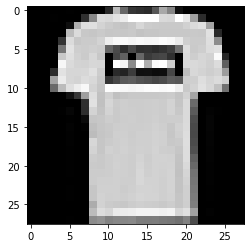

T-shirt


In [3]:
image, label = train_data[1]
plt.imshow(image.reshape(28,28), cmap='gray') # image is of 3d (1,28,28) need it in (28,28)
plt.show()
print(class_names[label])

In [4]:
train_data_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=20, shuffle=True)


Class:  ['Sandal' 'Trouser' 'Trouser' 'Coat' 'Sweater' 'Bag' 'Sandal' 'Trouser'
 'Boot' 'Sneaker' 'Sandal' 'Dress' 'Sandal' 'Sandal' 'Shirt' 'Shirt'
 'Shirt' 'Shirt' 'Dress' 'Shirt']


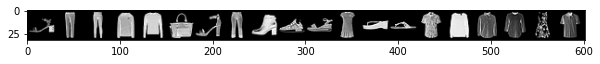

In [5]:
images,labels = next(iter(train_data_loader))
print('Class: ', np.array([class_names[i] for i in labels]))
im = make_grid(images, nrow=20)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.fc1 = nn.Linear(4*4*32, 128)
        self.fc2 = nn.Linear(128, 32)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 4*4*32) # flattens it
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [7]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_data_loader):
        b+=1
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        trn_corr += (torch.max(y_pred.data, 1)[1] == y_train).sum()
        loss.backward()
        optimizer.step()

    print(f'epoch: {i:2}  loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(20*b):7.3f}%')

    train_losses.append(loss.item())
    train_correct.append((trn_corr/b))

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_data_loader):
            b+=1
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append((tst_corr/b))

/Users/shree/.conda/envs/Machine_Learning_Codes/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  0  loss: 0.52598560 accuracy:  80.732%
epoch:  1  loss: 0.19611433 accuracy:  88.068%
epoch:  2  loss: 0.29865441 accuracy:  89.517%
epoch:  3  loss: 0.32750013 accuracy:  90.565%
epoch:  4  loss: 0.08408938 accuracy:  91.410%


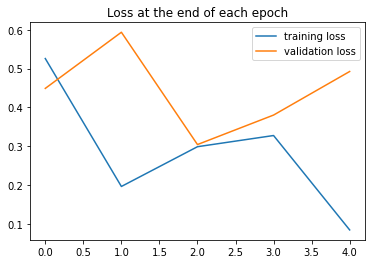

In [10]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

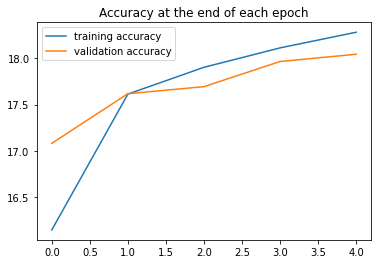

In [11]:
plt.plot(train_correct, label='training accuracy')
plt.plot(test_correct, label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show()